In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np

import openml

from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel, PennylaneKernel
from quask.evaluator import HaarEvaluator, LieRankEvaluator

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib as mpl

# Importance of Kernel Bandwidth in QML

Hi all in this tutorial!

The goal of this notebook is to leverage metrics in Quantum Machine Learning (QML) to obtain useful insights in a simple example. Kernel methods are very powerful but we know that we can encounter the orthogonality catastrophe. To avoid that we can use projected kernel, group invariant machine learning, and kernel bandwidth.
The first two require some knowledge about the dataset so that we can embed an **inductive bias** in our Quantum Kernels.
In the Kernel Bandwidth, we perform a global scaling of its features, making it a problem agnostic procedure. This kernel was introduced in [Importance of Kernel Bandwidth in Quantum Machine Learning](https://arxiv.org/abs/2211.16551) from which this tutorial takes its name.

You will see that the scaling of the kernel features affects the performance of a classification task and the Haar cost as defined in [Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum‐classical algorithms](https://arxiv.org/abs/1905.10876), while has no effect on the Lie Rank of the kernel introduced in [Diagnosing Barren Plateaus with Tools from Quantum Optimal Control](https://arxiv.org/abs/2105.14377).

In Quask there are more [evaluators](https://quask.readthedocs.io/en/latest/tutorials_quask/quask_1_evaluators.html) that can help you in a wide plethora of QML problems, it is your turn to find out!

## Fashion-MNIST Dataset

The Fashion-MNIST dataset is an image classification for distinguishing clothing items. We follow the preprocessing of the input data as done in [The power of data in Quantum Machine Learning](https://arxiv.org/abs/2011.01938). We use Principal Component Analysis (PCA) to reduce each image to an $n$-dimensional vector, the so-called **feature** vector.

Number of original examples: 70000
Unique classes in dataset: [0 1 2 3 4 5 6 7 8 9]
Number of filtered examples: 14000


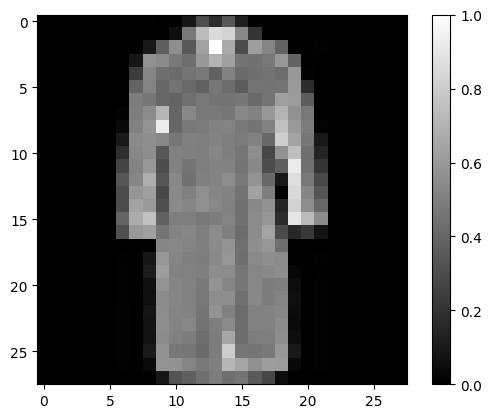

In [23]:
# Load the Fashion-MNIST dataset by its OpenML ID
dataset = openml.datasets.get_dataset(40996)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# Convert X to a NumPy array and normalize features from [0, 255] to [0, 1]
X = X.to_numpy().astype('float32') / 255.0
y = y.astype(int)

print("Number of original examples:", len(X))

# Check unique classes in the dataset
unique_classes = np.unique(y)
print("Unique classes in dataset:", unique_classes)

# Filter only two classes (0 and 3) for binary classification if they exist
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = (y == 0).astype(int)  # Convert class 0 to 1, class 3 to 0 for binary labels
    return x, y

if 0 in unique_classes and 3 in unique_classes:
    # Apply filter
    X, y = filter_03(X, y)
    print("Number of filtered examples:", len(X))

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    # Visualize a sample
    plt.imshow(X_train[0].reshape(28, 28), cmap="gray")
    plt.colorbar()
    plt.show()
else:
    print("Classes 0 and 3 not found in the dataset.")


In [4]:
# =============================================================================
# Create dataset
# =============================================================================  
def create_dataset(N_TRAIN: int, features_DIM: int, n_test: float = 0.2, prnt: bool=False):
    """
    create dataset

    This function loads data from the Fashion-MNIST dataset on OpenML
    and manipulates data to suit our problem, e.g., normalization and feature selection.

    N_TRAIN: int - number of training data to train our ML model
    features_DIM: int - number of features each datum will have. It corresponds to
                        the number of qubits if the encoding is one to one.
    n_test: float - percentage of datapoints we need for the test.
    """
    # Load the Fashion-MNIST dataset by its OpenML ID
    dataset = openml.datasets.get_dataset(40996)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

    # Convert X to a NumPy array and normalize features from [0, 255] to [0, 1]
    X = X.to_numpy().astype('float32') / 255.0
    y = y.astype(int)
    len_x_old = len(X)

    # Check unique classes in the dataset
    unique_classes = np.unique(y)

    # Filter only two classes (0 and 3) for binary classification if they exist
    def filter_03(x, y):
        keep = (y == 0) | (y == 3)
        x, y = x[keep], y[keep]
        y = (y == 0).astype(int)  # Convert class 0 to 1, class 3 to 0 for binary labels
        return x, y

    if 0 in unique_classes and 3 in unique_classes:
        # Apply filter
        X, y = filter_03(X, y)
        len_x_new = len(X)
        

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    # =============================================================================
    # Truncate x with PCA
    # =============================================================================
    def truncate_x(X_train, X_test, n_components=features_DIM):
        """
        Perform PCA on image dataset keeping the top n_components components.

        X_train: training dataset
        X_test: test dataset
        n_components: number of features we want to keep after PCA
        """
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        return X_train_pca, X_test_pca

    # Truncate dataset features
    X_train, X_test = truncate_x(X_train, X_test, n_components=features_DIM)

    # Restrict the dataset to N_TRAIN samples for training
    N_TEST = round(N_TRAIN * n_test)
    X_train, X_test = X_train[:N_TRAIN], X_test[:N_TEST]
    y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

    # Reshape to match desired feature dimension
    X_train = np.reshape(X_train, (len(X_train), features_DIM))
    X_test = np.reshape(X_test, (len(X_test), features_DIM))
    
    if prnt:
        print("Number of original examples:", len_x_old)
        print("Unique classes in dataset:", unique_classes)    
        print("Number of filtered examples:", len_x_new)
        print('Number of datapoints:', len(X_train))
        print('Data loaded.')
    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=800, features_DIM=5, prnt=True)
X_test.shape

## The Quantum Feature Map

Actually, the number of features for one image (thus, one circuit embedding) could be bigger than the number of qubits $d$ according to the feature map we pick. In this case we again refer to a well known feature map called Instantaneous Quantum Polynomial (IQP) feature map which was first introduced in [Supervised learning with quantum enhanced feature spaces](https://arxiv.org/abs/1804.11326). 

$$|\textbf{x}_i\rangle = U_{Z}(\textbf{x}_i) H^{\otimes d} U_{Z}(\textbf{x}_i) H^{\otimes d}|0^d\rangle$$

where

$$ U_{Z}(\textbf{x}_i) = \text{exp} \left( \sum_{j=1}^d \lambda x_{ij}Z_j + \sum_{j=1}^d \sum_{j'=1}^d \lambda^2 x_{ij} x_{ij'} Z_j Z_{j'} \right) \quad . $$

These unitaries form the ZZFeatureMap.  
Then, our feature array contains both the single-qubit and two-qubit features (the product of the single-qubit features pair entangled by the map scheme).

$$ \textbf{x}_i = (x_{i1}\;, x_{i2}\;, ..., x_{id}\;, \lambda x_{i1}x_{i2}\;, \lambda x_{i1}x_{i3}\;, ..., \lambda x_{id-1}x_{id}\;) .$$

The number of additional features depends on the type of entanglement we choose. The ZZFeatureMap has a full entanglement scheme which brings to an additional number of features equal to $\binom{d}{2}$. Finally, the total number of features for a single datapoint (as in, image) equals to $d + \binom{d}{2}$.

Below, you can find also two other feature maps, a Quantum Many-Body inspired one (can be found a similar one in  [Exploring entanglement and optimization within the hamiltonian variational ansatz](https://arxiv.org/abs/2008.02941)) and a single qubit $R_X$ rotations wall.

## Embedding the datapoints

In `QuASK`, we need to state both the number of features and operations that we are going to perform to construct the ansatz.

The number of operations we have to perform following the `IPQCircuit` map are:

$$ \underbrace{\left(d + \frac{d(d-1)}{2} \right)}_{U_{Z}(\textbf{x}_i)} + \underbrace{d}_{H^{\otimes d}} + \underbrace{\left(d + \frac{d(d-1)}{2} \right)}_{U_{Z}(\textbf{x}_i)} + \underbrace{d}_{H^{\otimes d}} $$

which is simply:

$$ d^2 + 3 d \quad .$$

While, the number of operations we have to perform following the `QMBCircuit` map are:

$$ \underbrace{\left(d-1\right)}_{U_{ZZ}(\textbf{x}_i\textbf{x}_{i+1})} + \underbrace{\left(d\right)}_{U_{X}(\textbf{x}_i)} $$

which is simply:

$$ 2d - 1 \quad .$$

And eventually, the number of operations we have to perform following the `LinearCircuit` map are simply:

$$ d \quad $$

since we perform only single qubit $R_X(\textbf{x}_i)$ rotations. So the number of features matches the number of qubits.

Henceforth, we are going to use only the linear kernel for the sake of time, but you are free to use also the other two which will be more time consuming.

In [ ]:
def create_pennylane_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return PennylaneKernel(ansatz, measurement, type, device_name="lightning.qubit", n_shots=None)

KernelFactory.add_implementation('pennylane_noiseless_lightning', create_pennylane_noiseless)
KernelFactory.set_current_implementation('pennylane_noiseless_lightning')
print(KernelFactory._KernelFactory__implementations)
print(KernelFactory._KernelFactory__current_implementation)

In [7]:
# =============================================================================
# IQP Kernel
# =============================================================================
def UZCircuit(ansatz, bandwidth, count=0):
    d = ansatz.n_qubits
    # Z term - local
    for k in range(d):
        ansatz.change_operation(count, new_feature=k, new_wires=[k, (k+1)%d], new_generator="IZ", new_bandwidth=bandwidth)
        count += 1

    # ZZ term - full entanglement 
    for i in range(d-1):
        for j in range(i+1, d):
            ansatz.change_operation(count, new_feature=k+i, new_wires=[i, j], new_generator="ZZ", new_bandwidth=bandwidth)
            count += 1

    return ansatz, count

def HCircuit(ansatz, bandwidth=1, count=0):
    d = ansatz.n_qubits
    n_features = d + d*(d-1)/2 + 1 # we have the last feature fixed to one for non-parametrizable gates
    for i in range(d):
        ansatz.change_operation(count, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="IX", new_bandwidth=np.pi/2) # R_x(pi/2)
        ansatz.change_operation(count+1, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="IZ", new_bandwidth=np.pi/2) # R_z(pi/2)
        ansatz.change_operation(count+2, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="IX", new_bandwidth=np.pi/2) # R_x(pi/2)
        ansatz.change_operation(count+3, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="II", new_bandwidth=np.pi)   # e^(i pi/2)

    count = count + 3
    return ansatz, count

def IQPCircuit(ansatz, bandwidth):
    # first U_Z(x_i)
    ansatz_uz1, count_uz1 = UZCircuit(ansatz, bandwidth)
    # first layer of hadamard gates
    ansatz_uz1h1, count_uz1h1 = HCircuit(ansatz_uz1, bandwidth, count=count_uz1)
    # second U_Z(x_i)
    ansatz_uz1h1uz2, count_uz1h1uz2 = UZCircuit(ansatz_uz1h1, bandwidth, count=count_uz1h1)
    # second layer of hadamard gates
    ansatz_uz1h1uz2h2, _ = HCircuit(ansatz_uz1h1uz2, bandwidth, count=count_uz1h1uz2)
    return ansatz_uz1h1uz2h2

# we can define a new function to construct the Ansatz since we will loop for different bandwidth values
def VaryingBandwidthQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # we choose a IQPCircuit
    circuit = IQPCircuit(ansatz, bandwidth)
    # kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.FIDELITY)
    kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel

# =============================================================================
# Ising-like Kernel
# =============================================================================
# help funciton to select on which qubit we want to perform our measurement
def measurement_qubit(N_QUBITS, measurement):
    pauli_string = ""
    for i in range(N_QUBITS):
        if i < measurement:
            pauli_string = pauli_string + "I"
        if i == measurement:
            pauli_string = pauli_string + "Z"
        if i > measurement:
            pauli_string = pauli_string + "I"
    return pauli_string

# let us define the Ansatz which implements this
def QMBCircuit(ansatz, bandwidth):
    d = ansatz.n_qubits
    # linear CZ entanglement
    for j in range(d-1):
        ansatz.change_operation(j, new_feature=d+j, new_wires=[j, j+1], new_generator="ZZ", new_bandwidth=bandwidth)

    # single qubit rotations in x: RX wall
    for i in range(d):
        j += 1
        ansatz.change_operation(j, new_feature=i, new_wires=[i, (i+1)%d], new_generator="IX", new_bandwidth=bandwidth)
    return ansatz

def ManyBodyQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth, measurement=None):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # we choose a IQPCircuit
    circuit = QMBCircuit(ansatz, bandwidth)
    kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.FIDELITY)
    # kernel = KernelFactory.create_kernel(circuit, measurement_qubit(N_QUBITS=N_QUBITS, measurement=measurement), KernelType.OBSERVABLE)
    # kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel


# =============================================================================
# Linear (single-qubit gates) Kernel
# =============================================================================
def LinearCircuit(ansatz, bandwidth):
    d = ansatz.n_qubits
    # single qubit rotations in x: RX wall
    for i in range(d):
        ansatz.change_operation(i, new_feature=i, new_wires=[i, (i+1)%d], new_generator="IX", new_bandwidth=bandwidth)
    return ansatz

def LinearQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth, platform="finite_shots", n_shots=None):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # choose linear circuit
    circuit = LinearCircuit(ansatz, bandwidth)

    kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.FIDELITY)
    # kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel

In [8]:
# modify the datapoints for quask

def quask_features_iqp(data, bandwidth):
    new_data = []
    for datapoint in data:
        new_datapoint = datapoint
        for i in range(len(datapoint)-1):
            for j in range(i+1, len(datapoint)):
                new_datapoint = np.append(new_datapoint, bandwidth*datapoint[i]*datapoint[j])
        new_datapoint = np.append(new_datapoint, 1)
        new_data.append(new_datapoint)
    new_data = np.array(new_data)
    return new_data

def quask_features_qmb(data):
    new_data = []
    for datapoint in data:
        new_datapoint = datapoint
        for i in range(len(datapoint)-1):
            new_datapoint = np.append(new_datapoint, datapoint[i]*datapoint[i+1])
        new_data.append(new_datapoint)
    new_data = np.array(new_data)
    return new_data

Some Help functions

In [9]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

def create_sequential_colors(num_colors, colormap_name: str='viridis'):
    """
    create_sequential_colors

    This function creates a sequence of colors extracted from a specified colormap.

    num_colors: int - number of colors we want to extract
    colormap_name: string - colormap name we want to use

    """
    colormap = mpl.colormaps[colormap_name]
    colormap_values = np.linspace(0, 1, num_colors)
    colors = [colormap(value) for value in colormap_values]
    return colors

## `Qiskit` with `QuASK`

Add a qiskit kernel to the QuASK Kernel factory. This object will then become an implementation which you can call for general ansatz. In particular, we now create a noiseless one

In [ ]:
def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, platform="infty_shots")

KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')
print(KernelFactory._KernelFactory__implementations)
print(KernelFactory._KernelFactory__current_implementation)

### Example of overlap circuit

As expected, the overlaps of the data with themselves are: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(1.0000000000000002), np.float64(1.0), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(1.0)]


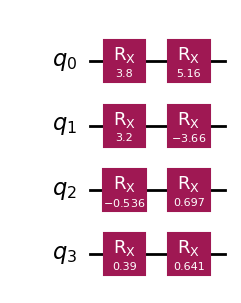

In [11]:
from qiskit.circuit.library import UnitaryOverlap
d = 4
n_tr = 10
X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=1)
kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=1)
kernel.platform = "infty_shots"
print(f"As expected, the overlaps of the data with themselves are: {[kernel.kappa(X_train[i],X_train[i]) for i in range(X_train.shape[0])]}")
qc1 = kernel.get_qiskit_ansatz().assign_parameters(X_train[5])
qc2 = kernel.get_qiskit_ansatz().assign_parameters(X_train[9])
qc = UnitaryOverlap(qc1,qc2)
qc.decompose(reps=1).draw('mpl')

### Quantum Kernel Estimation in a classification problem

Run the Fashion-MNIST with `LinearQuantumKernel`, changing $\beta$ the bandwidth scaling factor inside the local rotations $R_X(\beta\textbf{x}_i)$.

If you want to run the below problem with finite shots instead of infinite use:

In [12]:
# def create_qiskit_kernel(ansatz: Ansatz, measurement: str, type: KernelType):
#     return QiskitKernel(ansatz, measurement, type, platform="finite_shots")

# KernelFactory.add_implementation('qiskit_shots', create_qiskit_kernel)
# KernelFactory.set_current_implementation('qiskit_shots')
# print(KernelFactory._KernelFactory__implementations)

n_shots = None # define shots if you want to run with this

In [ ]:
n_tr = 30
num_qubits = [3]
bandwidths = np.logspace(-3,1,20)
accuracy_qubit = []
for d in num_qubits:
    # features_quask_iqp = d + d*(d-1)/2 + 1
    # features_quask_qmb = 2*d - 1
    # operations_quask_iqp = d**2 + 3*d 
    # operations_quask_qmb = 2*d - 1 

    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=0.3)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])

    accuracy_beta = []
    for beta in bandwidths:
        print(f"Qubits: {d}, beta: {beta}")
        # X_train_q = quask_features_iqp(X_train, beta)
        # X_test_q = quask_features_iqp(X_test, beta)
        # kernel = ManyBodyAnsatz(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta, measurement=2)
        # kernel = VaryingBandwidthKernel(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta)
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        # kernel.n_shots = n_shots # uncomment if you run with finite shots
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train, matrix="train")
        print("building testing kernel...")
        K_test = kernel.build_kernel(X_test, X_train, matrix="test")
        print("computing accuracy...")
        svm = SVC(kernel='precomputed').fit(K_train, y_train)
        accuracy_res = accuracy(svm, K_test, y_test)
        accuracy_beta.append(accuracy_res)
    accuracy_qubit.append(accuracy_beta)

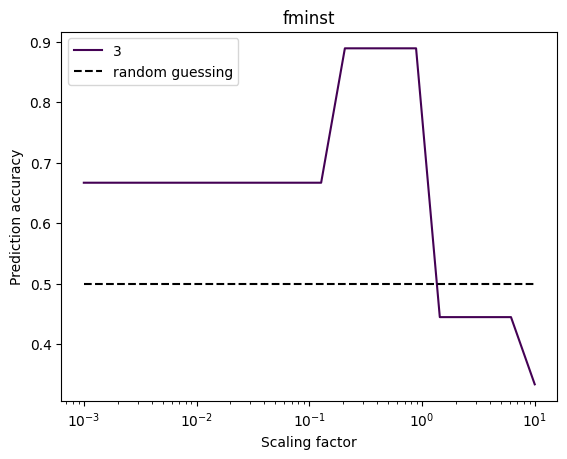

In [18]:
# plot the results
colors = create_sequential_colors(num_qubits[0])

plt.plot(bandwidths, accuracy_beta, color=colors[0], label=f"{num_qubits[0]}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=bandwidths[0], xmax=bandwidths[-1], linestyles='--', colors='black', label="random guessing")
plt.legend()

### Inifite $vs$ Finite shots kernels

In [ ]:
def create_qiskit_kernel(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, platform="finite_shots")

# KernelFactory.add_implementation('qiskit_shots', create_qiskit_kernel)
KernelFactory.set_current_implementation('qiskit_shots')
print(KernelFactory._KernelFactory__implementations)

{'qiskit_noiseless': <function create_qiskit_noiseless at 0x0000011B73142A20>, 'qiskit_shots': <function create_qiskit_finite_shots at 0x0000011B8C0B6A20>, 'qiskit_kernel': <function create_qiskit_kernel at 0x0000011B8C96E5C0>}


In [ ]:
# Number of runs to estimate the standard deviation
num_runs = 10
shots_list = [10,100,1000]
# Initialize lists to store accuracies for multiple runs
acc_shots_qis = []
beta_best = bandwidths[np.argmax(accuracy_beta)]

# Iterate over the number of shots
for n_shots in shots_list:
    n_shots = int(n_shots)
    print(f"Shots: {n_shots}")
    
    # Initialize lists for accuracies of current shot count
    qis_accuracies = []
    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")

        # Qiskit Kernel Estimation
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta_best)
        kernel.n_shots = n_shots
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train, matrix="train")
        print("building testing kernel...")
        K_test = kernel.build_kernel(X_test, X_train, matrix="test")
        print("computing accuracy...")
        svm = SVC(kernel='precomputed').fit(K_train, y_train)
        accuracy_res = accuracy(svm, K_test, y_test)
        qis_accuracies.append(accuracy_res)

    # Append mean accuracy and standard deviation for Qiskit
    acc_shots_qis.append({
        'shots': n_shots,
        'mean': np.mean(qis_accuracies),
        'std': np.std(qis_accuracies)
    })

    # Print mean and standard deviation for current number of shots
    # print(f"Pennylane Kernel (shots={n_shots}): Mean accuracy = {np.mean(penn_accuracies):.3f}, Std = {np.std(penn_accuracies):.3f}")
    print(f"Qiskit Kernel (shots={n_shots}): Mean accuracy = {np.mean(qis_accuracies):.3f}, Std = {np.std(qis_accuracies):.3f}")

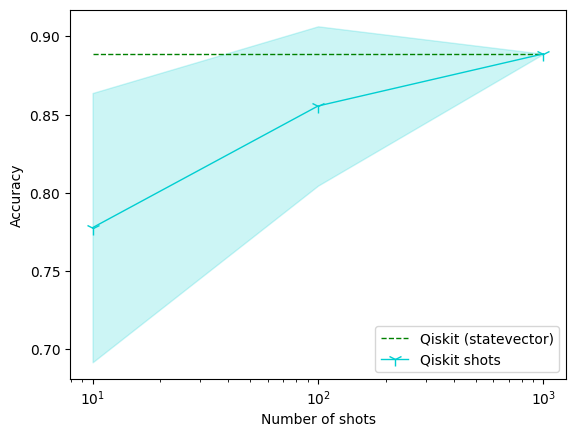

In [156]:
exact_qiskit = np.max(accuracy_beta)
# Plot the exact statevector results as horizontal lines
plt.hlines(y=exact_qiskit, xmin=shots_list[0], xmax=shots_list[-1], linestyle='--', color='g', linewidth=1, label='Qiskit (statevector)')

# Plot the Qiskit results with error bars (mean accuracy and standard deviation)
qis_means = [entry['mean'] for entry in acc_shots_qis]
qis_stds = [entry['std'] for entry in acc_shots_qis]
plt.plot(shots_list, qis_means, marker='1', markersize=10, linewidth=1, label='Qiskit shots', color='darkturquoise')
plt.fill_between(shots_list, 
                 [m - s for m, s in zip(qis_means, qis_stds)], 
                 [m + s for m, s in zip(qis_means, qis_stds)], 
                 color='darkturquoise', alpha=0.2)

# Set logarithmic scale for the x-axis (number of shots)
plt.xscale('log')

# Labels and legend
plt.xlabel("Number of shots")
plt.ylabel("Accuracy")
plt.legend()

# Show the plot
plt.show()

## ``Haar evaluator`` with `Quask`

In [ ]:
KernelFactory.set_current_implementation('qiskit_noiseless')
for d in num_qubits:

    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=0.3)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])

    cost_he_beta = []
    cost_lre_beta = []
    for beta in bandwidths:
        print(f"Qubits: {d}, beta: {beta}")
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train, matrix="train")
        print("Haar evaluator...")
        he = HaarEvaluator(n_bins=40, n_samples=n_tr)
        cost_he = he.evaluate(kernel=kernel, K=K_train, X=None, y=None)
        print(f"--- {cost_he}")
        print("Lie Rank evaluator...")
        lre = LieRankEvaluator(T=500)
        cost_lre = lre.evaluate(kernel=kernel, K=None, X=None, y=None)
        print(f"--- {cost_lre}")
        cost_he_beta.append(cost_he)
        cost_lre_beta.append(-cost_lre)

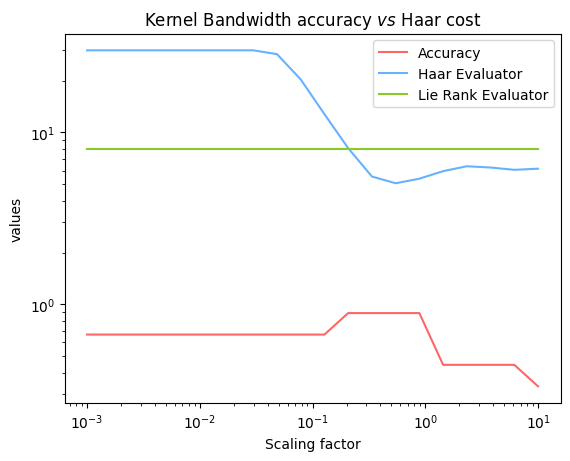

In [21]:
# plot the results
colors = ['#FF6666', '#66B2FF', '#8AC926']

plt.plot(bandwidths, accuracy_beta, color=colors[0], label=f"Accuracy")
plt.plot(bandwidths, cost_he_beta, color=colors[1], label=f"Haar Evaluator")
plt.plot(bandwidths, cost_lre_beta, color=colors[2], label=f"Lie Rank Evaluator")
plt.xscale('log')
plt.yscale('log')
plt.title("Kernel Bandwidth accuracy $vs$ Haar cost")
plt.xlabel("Scaling factor")
plt.ylabel("values")
# plt.hlines(y=0.5, xmin=bandwidths[0], xmax=bandwidths[-1], linestyles='--', colors='black', label="random guessing")
plt.legend()

## IBM Quantum Hardware with `Quask`

For the sake of simplicity we perform a small example where we use one of the IBM QPUs to estimate an entry of our Quantum Kernel matrix. Quask creates kernels independently from the backend as abstract objects. To use `qiskit` we specify the argument `platform`.

In [38]:
from quask.core_implementation import QiskitKernel
def create_qiskit_kernel(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, platform="ibm_quantum")

KernelFactory.add_implementation('qiskit_kernel_qpu', create_qiskit_kernel)
KernelFactory.set_current_implementation('qiskit_kernel_qpu')
print(KernelFactory._KernelFactory__implementations)

{'qiskit_noiseless': <function create_qiskit_noiseless at 0x0000011B73142A20>, 'qiskit_shots': <function create_qiskit_finite_shots at 0x0000011B8C0B6A20>, 'qiskit_kernel': <function create_qiskit_kernel at 0x0000011B8C96E5C0>}


In [60]:
channel = "ibm_quantum"
platform = channel

# do not define any device for 'least_busy()' option
## Open Plan devices
device = "ibm_kyiv"
# device = "ibm_sherbrooke"
# device = "ibm_brisbane"

## Premium Plan devices
# device = "ibm_torino"
# device = "ibm_fez"


ibm_token = "" # insert here your ibm token
# group_instance = "ibm-q-ikerbasque/generic/generic-project" # insert here your ibm group instance relative to your project
group_instance = "ibm-q/open/main" # insert here your free access ibm instance

In [61]:
# backend options
n_shots = 10000
dd_seq = "XY4"
tw_g = True
tw_m = True

sampler_options = {
    "default_shots": n_shots,
    "dynamical_decoupling": {
        "enable": bool(dd_seq),
        "sequence_type": dd_seq
    },
    "twirling": {
        "enable_gates": tw_g,
        "enable_measure": tw_m,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

# transpilation options
layout = None
optimization_level = 2

In [62]:
# create the linear kernel for backend support and initialize it
d = 3 
kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=bandwidths[-3])
kernel.get_backend(channel, ibm_token, group_instance, device)
kernel.platform = platform
kernel.n_shots = n_shots
kernel.options = sampler_options
kernel.optimization_level = optimization_level
kernel.layout = layout

Send job to the QPU selected

In [66]:
# the kernel in fully initialized and we can execute to the hardware
kernel_entry_job = kernel.build_kernel(X_train[15], X_train[29])

Job sent to hardware. Job ID: cwgfd1w9r49g00860h70


We can plot the sampling of the different configurations 

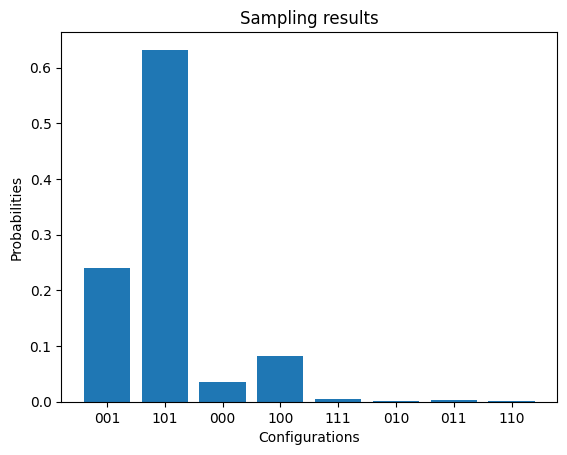

In [81]:
counts = kernel_entry_job.result()[0].data.meas.get_counts()
keys = [key for key, value in counts.items()]
values = [value/n_shots for key, value in counts.items()]

container = plt.bar(keys, values, width=0.8)

plt.title('Sampling results')
plt.xlabel('Configurations')
plt.ylabel('Probabilities')

plt.show()

In [77]:
# get the kernel entry after the job is finished
kernel_entry = kernel.get_job_results(kernel_entry_job)
kernel_entry

0.0363

We computed the overlap between two different datapoints on the Quantum Hardware